In [1]:
from fuzzyART_gai import *
from kit_handy import *
from kit_painting import *
import matplotlib.pyplot as plt

In [2]:
data, label_true = load_data('gaussian2d') # iris
pca_painter = PaintPCA(data)

Variance explained by first 2 principal components: [0.65131614 0.34868386]


In [3]:
# use FuzzyART
# init
rho = 0.6
net = FuzzyARTgai(alpha=0.5, rho=rho) # for the current iris data, rho near 0.65 seems the best in clustering data

# train
net.train(data, epochs=100) # each epoch, all data is shuffled

figure saved at _simcache/2022-04-01_12-21-56_var_rho60


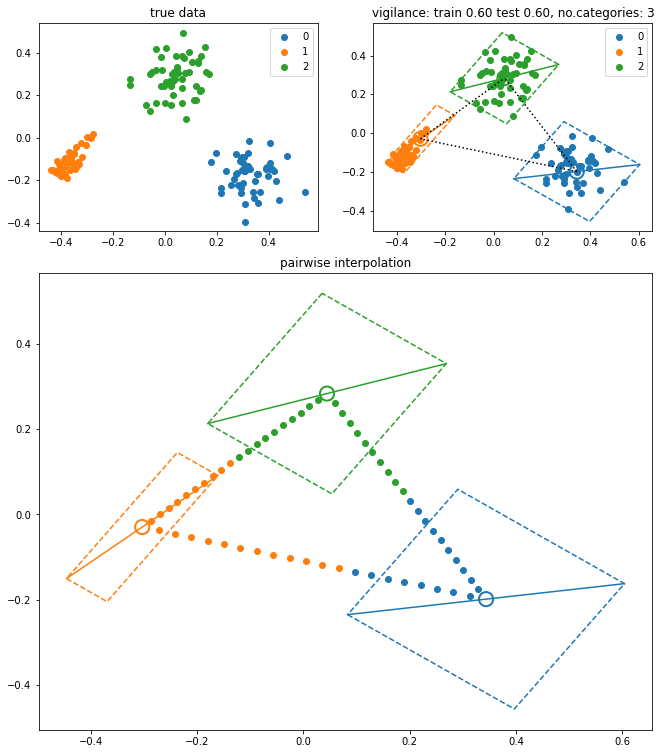

In [4]:
fig, axs = plt.subplot_mosaic("""
                                AB
                                CC
                                CC
                                """,
                                figsize=(11, 13))
#fig.tight_layout()

# plot true data
pca_painter.scatter(axs['A'], label_true)
axs['A'].set_title("true data")

# test
test_rho = rho
isdiff_traintest = net._set_properties(rho = test_rho)
label_pred = net.test(data).astype(int)

# plot
# pred
pca_painter.scatter(axs['B'], label_pred, data)

for k in 'BC':
    # bipole and centre
    pca_painter.tripole(axs[k], *net.getcat_bipole())

    # boundary    
    axs[k].set_prop_cycle(None)
    pca_painter.boundary(axs[k], net.getcat_vertex()) 

# interpolate centres
cat_centres = net.getcat_centre()
pca_cat_centres = pca_painter.pca.transform(cat_centres)
cat_number = cat_centres.shape[0]
ls_interidx, ls_intercat = [], []
for i in range(cat_number):
    for j in range(i + 1, cat_number):
        interidx = np.array([i, j])
        ls_interidx.append(interidx) 
        axs['B'].plot(*pca_cat_centres[interidx].T, c = 'k', ls = 'dotted')
        
        intercat = interp2coordinates(*cat_centres[interidx], 20)
        intercat_label = net.test(intercat).astype(int)
        ls_intercat.append(intercat_label)
        axs['C'].set_prop_cycle(None)
        pca_painter.scatter(axs['C'], intercat_label, intercat)
        
# info
axs['B'].set_title('vigilance: train {:.2f} test {:.2f}, no.categories: {}'.format(rho, test_rho, cat_number))
axs['C'].set_title('pairwise interpolation')

# save fig
simname = 'var_rho{:d}'.format(int(rho*100))
dirname = '_simcache'
savefigure_datetime(fig, simname, dirname)
    
for k in 'AB':
    axs[k].legend()